In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, segmentation, exposure, feature
from skimage.filters import frangi, gabor
from scipy import ndimage as ndi

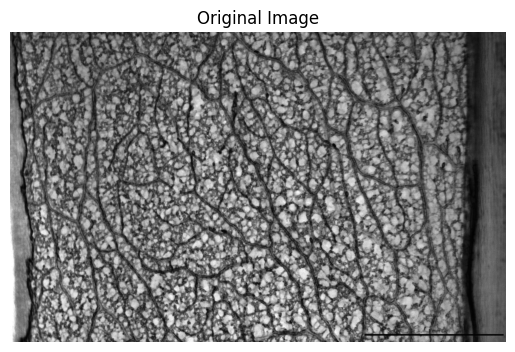

255


In [ ]:
img = cv2.imread("datasets/laticifers/enhanced_images/Hoja 1-1.tif", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

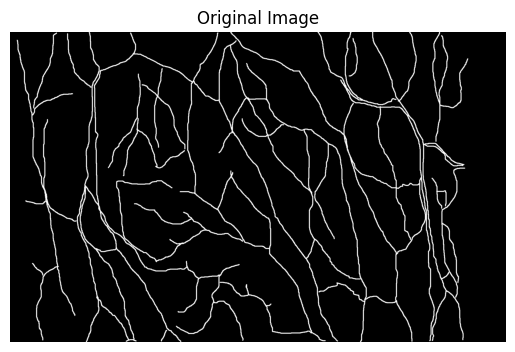

In [3]:
mask = cv2.imread("datasets/laticifers/masks/Hoja 1-1.tif", cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Otsu Thresholding')

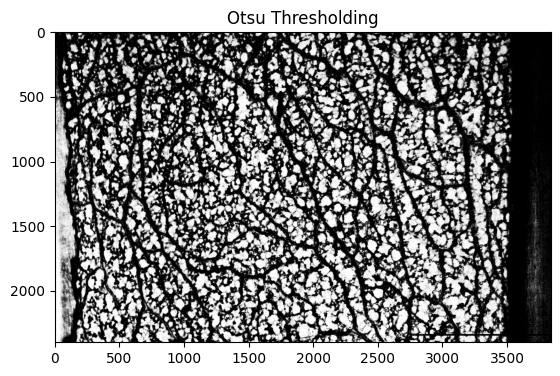

In [4]:
otsu_thresh = filters.threshold_otsu(img)
binary_otsu = img > otsu_thresh
plt.imshow(binary_otsu, cmap='gray')
plt.title("Otsu Thresholding")

Text(0.5, 1.0, 'Adaptive Thresholding')

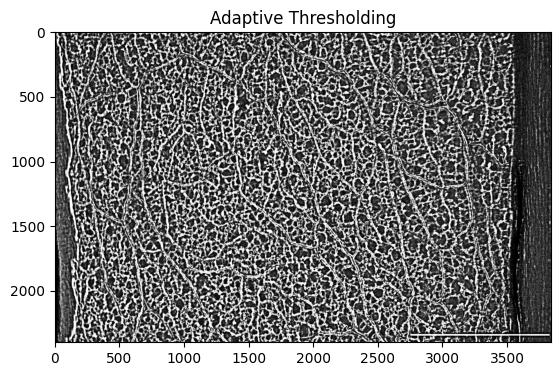

In [5]:
adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                 cv2.THRESH_BINARY_INV, 35, 10)
plt.imshow(adaptive, cmap='gray')
plt.title("Adaptive Thresholding")

/tmp/ipykernel_942707/2373008144.py:5: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  frangi_img = frangi(img_norm, scale_range=(15, 40), scale_step=2)


Text(0.5, 1.0, 'Frangi Filter (vesselness)')

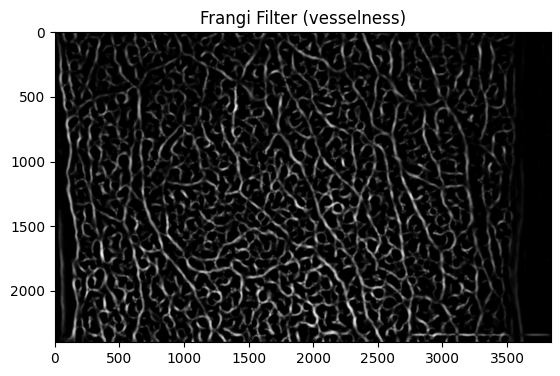

In [6]:
from skimage.filters import frangi
from skimage import img_as_float

img_norm = img_as_float(img)  # normalize to 0–1
frangi_img = frangi(img_norm, scale_range=(15, 40), scale_step=2)
frangi_img_vis = (frangi_img * 255).astype(np.uint8)

plt.imshow(frangi_img_vis, cmap='gray')
plt.title("Frangi Filter (vesselness)")


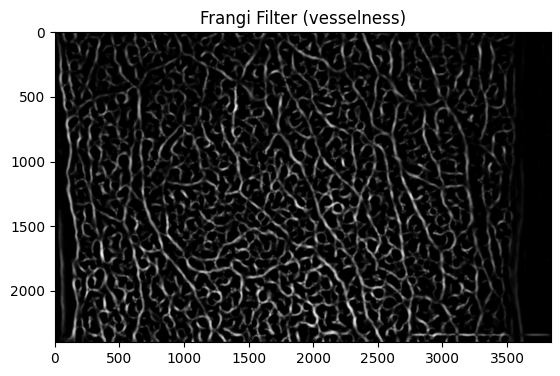

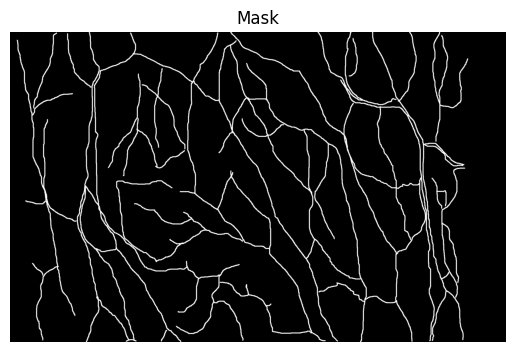

In [7]:
plt.imshow(frangi_img_vis, cmap='gray')
plt.title("Frangi Filter (vesselness)")

plt.figure()
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Gabor Filter Bank Output')

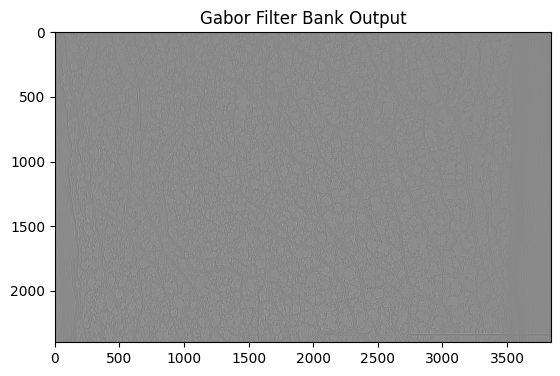

In [8]:
def apply_gabor_bank(image, frequencies=[0.1, 0.2], thetas=np.linspace(0, np.pi, 6)):
    accum = np.zeros_like(image, dtype=np.float32)
    for theta in thetas:
        for freq in frequencies:
            filt_real, _ = gabor(image, frequency=freq, theta=theta)
            accum += filt_real
    accum /= (len(thetas) * len(frequencies))
    return accum

img_float = img_as_float(img)
gabor_response = apply_gabor_bank(img_float)
gabor_vis = (gabor_response - gabor_response.min()) / (gabor_response.max() - gabor_response.min())

plt.imshow(gabor_vis, cmap='gray')
plt.title("Gabor Filter Bank Output")


Text(0.5, 1.0, 'Gabor Filter Bank Output')

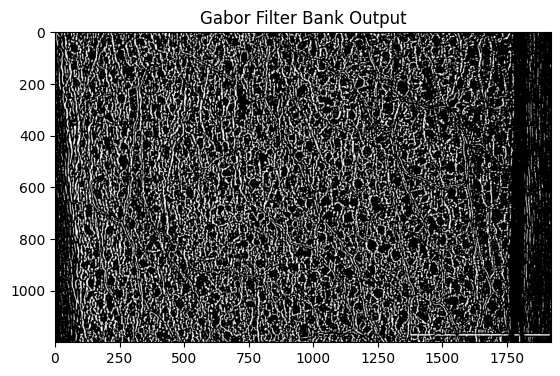

In [ ]:
def apply_gabor_bank(image, frequencies=[0.1, 0.2], thetas=np.linspace(0, np.pi, 6)):
    accum = np.zeros_like(image, dtype=np.float32)
    for theta in thetas:
        for freq in frequencies:
            filt_real, _ = gabor(image, frequency=freq, theta=theta)
            accum += filt_real
    accum /= (len(thetas) * len(frequencies))
    return accum

img_float = img_as_float(img)
gabor_response = apply_gabor_bank(img_float)
gabor_vis = (gabor_response * 255).astype(np.uint8)

plt.imshow(gabor_vis, cmap='gray')
plt.title("Gabor Filter Bank Output")

Text(0.5, 1.0, 'sato')

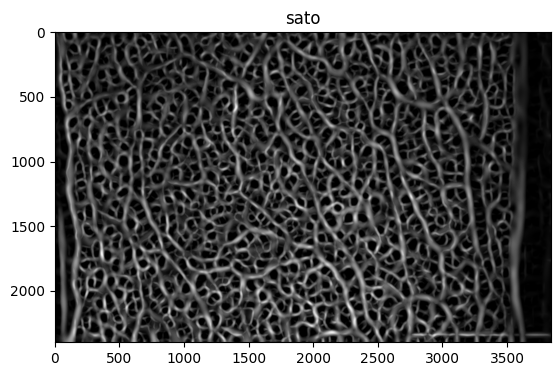

In [ ]:
from skimage.filters import sato
sato_sigmas = range(15, 30, 2)
vesselness = sato(img, sigmas=sato_sigmas)
plt.imshow(vesselness, cmap='gray')
plt.title("sato")

Text(0.5, 1.0, 'sato')

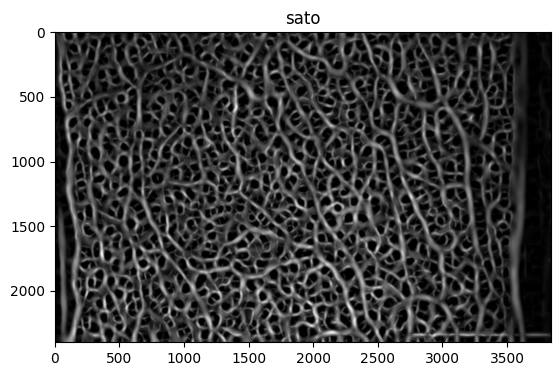

In [4]:
from skimage.filters import sato
sato_sigmas = range(15, 30, 2)
vesselness = sato(img, sigmas=sato_sigmas)
plt.imshow(vesselness, cmap='gray')
plt.title("sato")

0 255


Text(0.5, 1.0, 'Canny + Morphology')

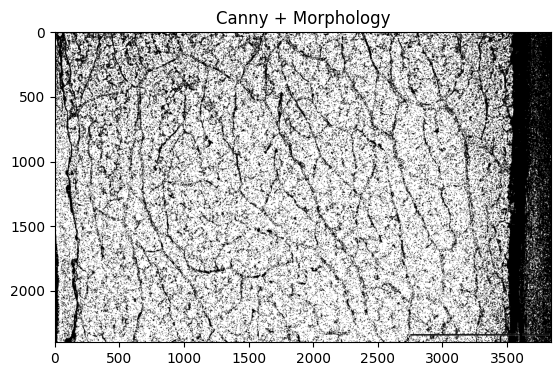

In [10]:
blurred = cv2.GaussianBlur(img, (3, 3), 0)
edges = cv2.Canny(blurred, threshold1=50, threshold2=80)

# Clean up with morphology
closed = morphology.binary_closing(edges > 0.5, morphology.disk(2))
cleaned = morphology.remove_small_objects(closed, min_size=300)
print(edges.min(), edges.max())
plt.imshow(closed, cmap='gray')
plt.title("Canny + Morphology")

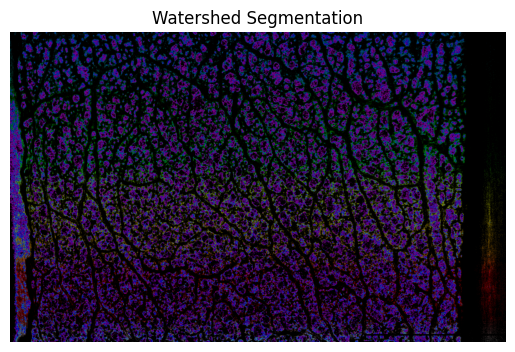

In [ ]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label

# Binary mask from thresholding
binary = binary_otsu  # Or whichever binary mask you're using
# Compute the distance transform
distance = ndi.distance_transform_edt(binary)
# Get coordinates of local maxima
coords = peak_local_max(distance, labels=binary, footprint=np.ones((3, 3)), exclude_border=False)
# Create a marker image from the coordinates
markers = np.zeros_like(distance, dtype=np.int32)
for i, coord in enumerate(coords, start=1):
    markers[tuple(coord)] = i

# Apply watershed
labels_ws = watershed(-distance, markers, mask=binary)

# Plot
plt.imshow(labels_ws, cmap='gray')
plt.title("Watershed Segmentation")
plt.axis('off')
plt.show()


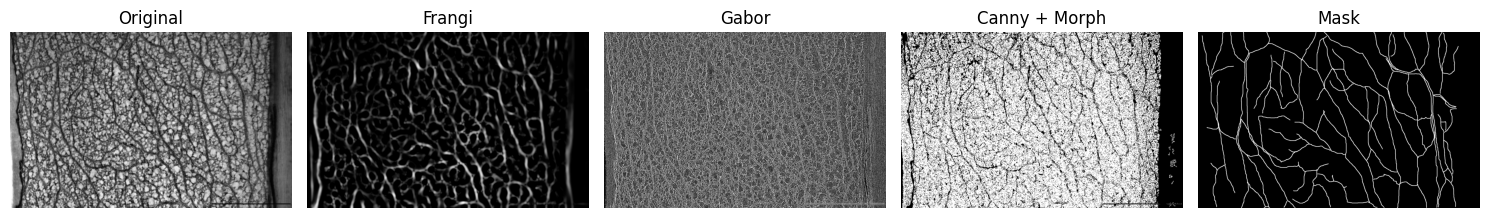

In [12]:
def show_images(images, titles, cmap='gray'):
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i], cmap=cmap)
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
show_images([img, frangi_img_vis, gabor_vis, cleaned, mask],
            ["Original", "Frangi", "Gabor", "Canny + Morph", "Mask"])

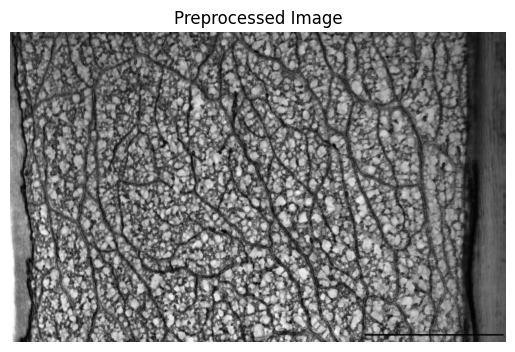

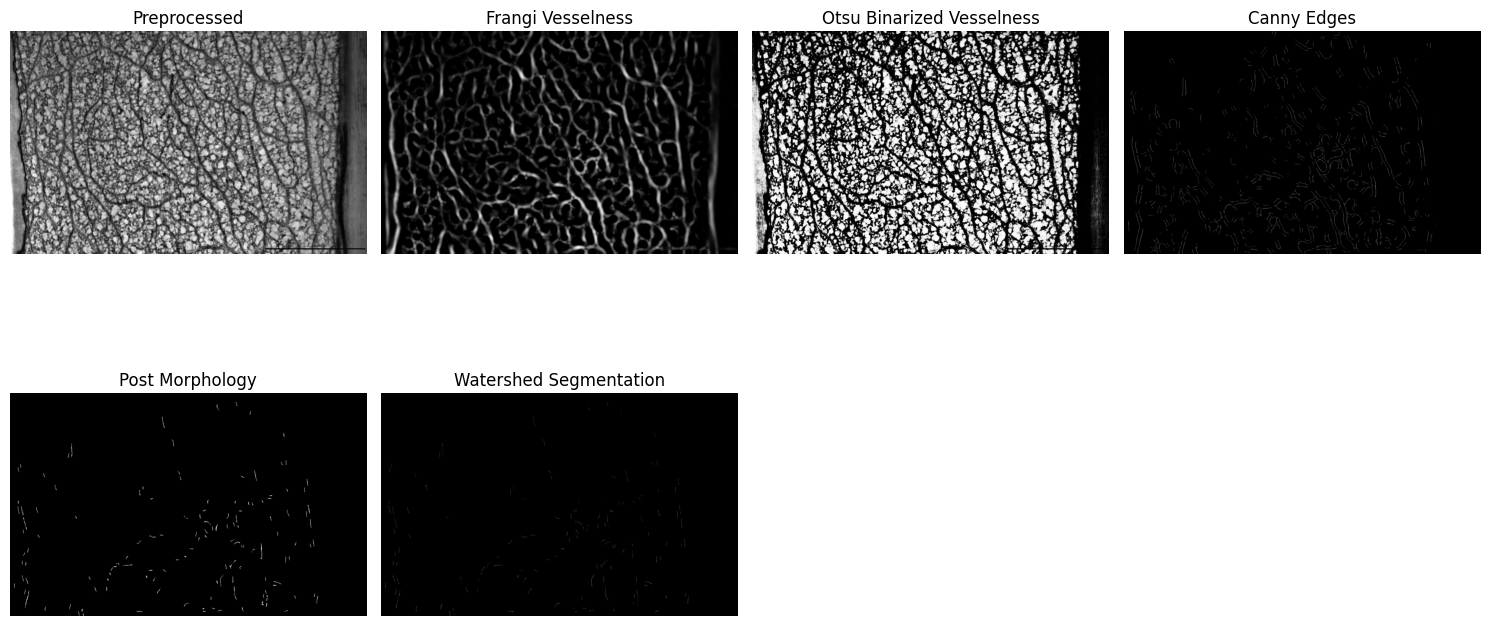

In [ ]:
 %%
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, exposure
from skimage.filters import frangi, gabor
from skimage import img_as_float, img_as_ubyte
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

# %%
# Load grayscale CLAHE-enhanced image
img = cv2.imread("datasets/laticifers/enhanced_images/Hoja 1-1.tif", cv2.IMREAD_GRAYSCALE)
#img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)  # Optional downsampling for speed
#img = exposure.equalize_adapthist(img)         # Double CLAHE if needed
img_float = img_as_float(img)

plt.imshow(img_float, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()

# %%
# Step 1: Vessel Enhancement using Frangi Filter
vesselness = frangi(img_float, sigmas=np.arange(30, 40, 2))
vessel_bin = img_float > filters.threshold_otsu(img_float)

# %%
# Step 2: Canny Edge Detection on Vessel-Enhanced Image
blurred = cv2.GaussianBlur(img_as_ubyte(vesselness), (3, 3), 0)
edges = cv2.Canny(blurred, 20, 50)

# %%
# Step 3: Morphological Enhancement
edges_closed = morphology.binary_closing(edges > 0, morphology.disk(2))
edges_cleaned = morphology.remove_small_objects(edges_closed, min_size=150)

# %%
# Step 4: Watershed to separate overlapping ducts
distance = ndi.distance_transform_edt(edges_cleaned)
coords = peak_local_max(distance, labels=edges_cleaned, footprint=np.ones((3, 3)), exclude_border=False)
markers = np.zeros_like(distance, dtype=np.int32)
for i, coord in enumerate(coords, start=1):
    markers[tuple(coord)] = i

labels_ws = watershed(-distance, markers, mask=edges_cleaned)

# %%
# Visual Results
def show(images, titles, cmap='gray'):
    plt.figure(figsize=(15, 8))
    for i in range(len(images)):
        plt.subplot(2, len(images)//2 + 1, i+1)
        plt.imshow(images[i], cmap=cmap)
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show(
    [img_float, vesselness, vessel_bin, edges, edges_cleaned, labels_ws],
    ["Preprocessed", "Frangi Vesselness", "Otsu Binarized Vesselness", 
     "Canny Edges", "Post Morphology", "Watershed Segmentation"]
)
